In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neo
from pathlib import Path

In [2]:
data_dir = Path(r'R:\home\firefly_link\468_patch_clamp')
files = Path(data_dir).glob("./**/*.smr")
smr_names = [str(f) for f in files]
dates = []
slips = []
cells = []
trial_string = []
df = pd.DataFrame()
df['SMR_file'] = smr_names

for data in df.itertuples():
    s = data.SMR_file

    par = Path(s).parts

    dates.append(int(par[par.index("468_patch_clamp") + 1][-8:]))
    
    slips.append(s[s.find("slip") + len("slip") : s.find("slip") + len("slip") + 1])

    cells.append(s[s.find("cell") + len("cell") : s.find("cell") + len("cell") + 1])
   
    trial_string.append("_".join(Path(s).parts[Path(s).parts.index("468_patch_clamp") : -1]))
df["date"] = dates
df["slip"] = slips
df["cell"] = cells
df["trial_string"] = trial_string
df = df[df['date']>20231108]
expt = []
for data in df.itertuples():
    s=data.SMR_file
    if 'ibtx' in s.lower():
        expt.append('ibtx')
    elif 'apamin' in s.lower():
        expt.append('apamin')
    else:
        expt.append('none')
df['expt'] = expt
df['use'] = 'y'
#df.to_csv(Path(data_dir,'dataframes','patch468_20231130.csv'))
df

,SMR_file,date,slip,cell,trial_string,expt,use
62,R:\home\firefly_link\468_patch_clamp\20231129\...,20231129,1,1,468_patch_clamp_20231129_slip1_cell1,ibtx,y
63,R:\home\firefly_link\468_patch_clamp\20231129\...,20231129,2,1,468_patch_clamp_20231129_slip2_cell1,ibtx,y
64,R:\home\firefly_link\468_patch_clamp\20231129\...,20231129,3,1,468_patch_clamp_20231129_slip3_cell1,ibtx,y
65,R:\home\firefly_link\468_patch_clamp\20231129\...,20231129,4,1,468_patch_clamp_20231129_slip4_cell1,ibtx,y
66,R:\home\firefly_link\468_patch_clamp\20231129\...,20231129,5,1,468_patch_clamp_20231129_slip5_cell1,apamin,y
67,R:\home\firefly_link\468_patch_clamp\20231129\...,20231129,6,1,468_patch_clamp_20231129_slip6_cell1,apamin,y
68,R:\home\firefly_link\468_patch_clamp\20231129\...,20231129,7,1,468_patch_clamp_20231129_slip7_cell1,apamin,y


In [3]:
save_dir = Path(r'R:\home\firefly_link\468_patch_clamp\results_profiles')

In [4]:
index = 62
reader = neo.io.Spike2IO(filename=df.SMR_file[index],try_signal_grouping=False)
# read the block
bl = reader.read(lazy=False)[0]
#bl

In [5]:
asig_t = bl.segments[0].analogsignals[0]
# Extract sample times
#times = asig_t.times.rescale('s').magnitude
# Determine channel name, without leading b' 
asig = asig_t
ch = asig.name
V_cc = {}
I_cc = {}
V_vc = {}
I_vc = {}
# Extract sampling frequency
fs = float(asig.sampling_rate)
# Assign sampling times, sampling frequency and data to correct dictionary
for asig in bl.segments[0].analogsignals:
    ch = asig.name
    times = asig.times.rescale('s').magnitude
    if ch == 'V_cc':
        
        V_cc['times'] = times
        V_cc['signal'] = np.array(asig)
        #V_cc['fs'] = fs
    elif ch == 'I_cc':
        
        I_cc['times'] = times
        I_cc['signal'] = np.array(asig)
        #I_cc['fs'] = fs
        
    elif ch == 'I_vc':
        
        I_vc['times'] = times
        I_vc['signal'] = np.array(asig)
    
    elif ch == 'V_vc':
        
        V_vc['times'] = times
        V_vc['signal'] = np.array(asig)
        
V = np.squeeze(V_vc['signal'])
I = np.squeeze(I_vc['signal'])

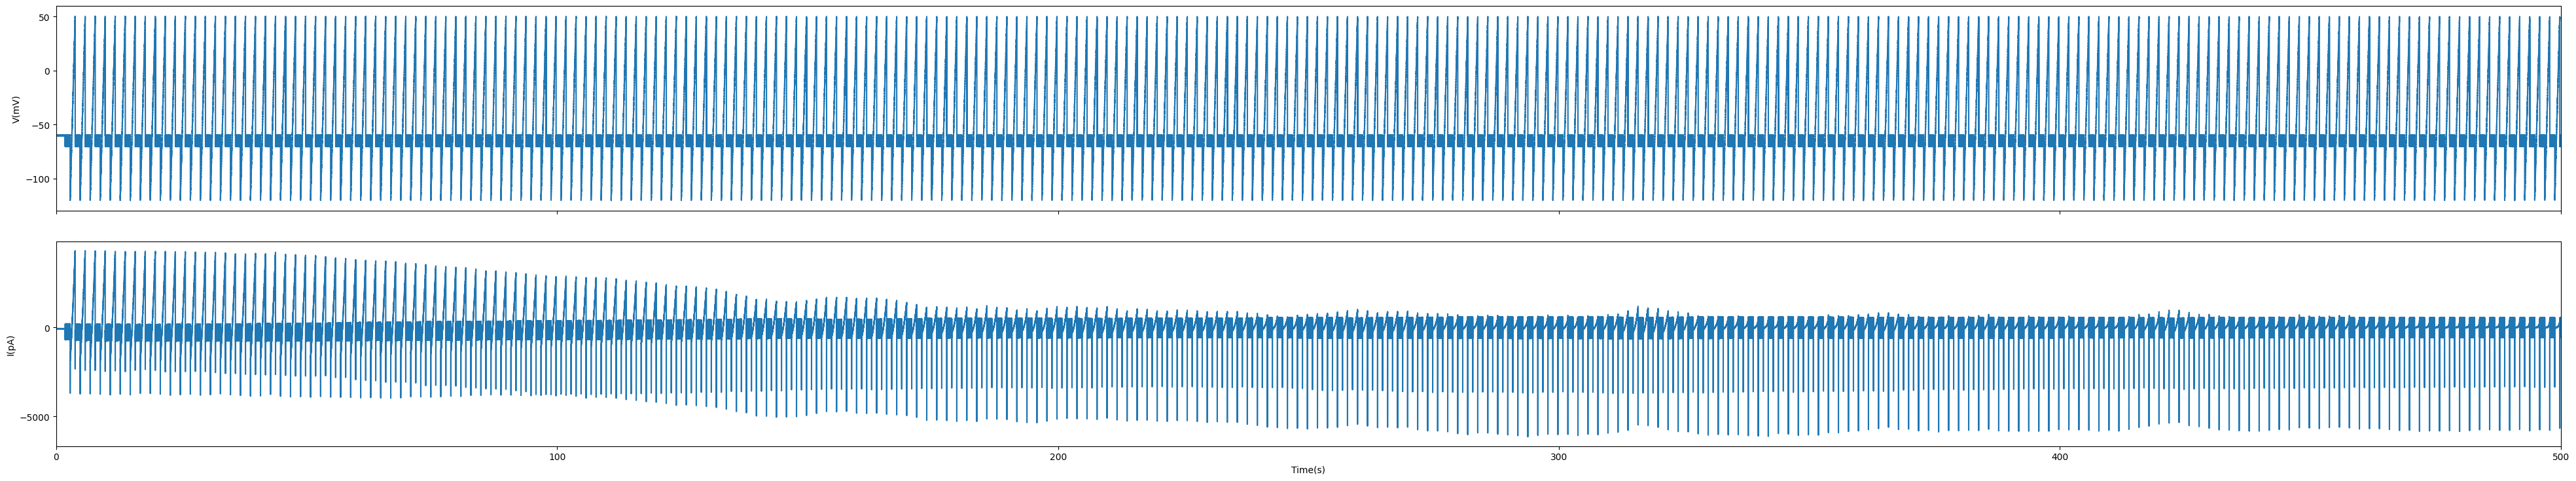

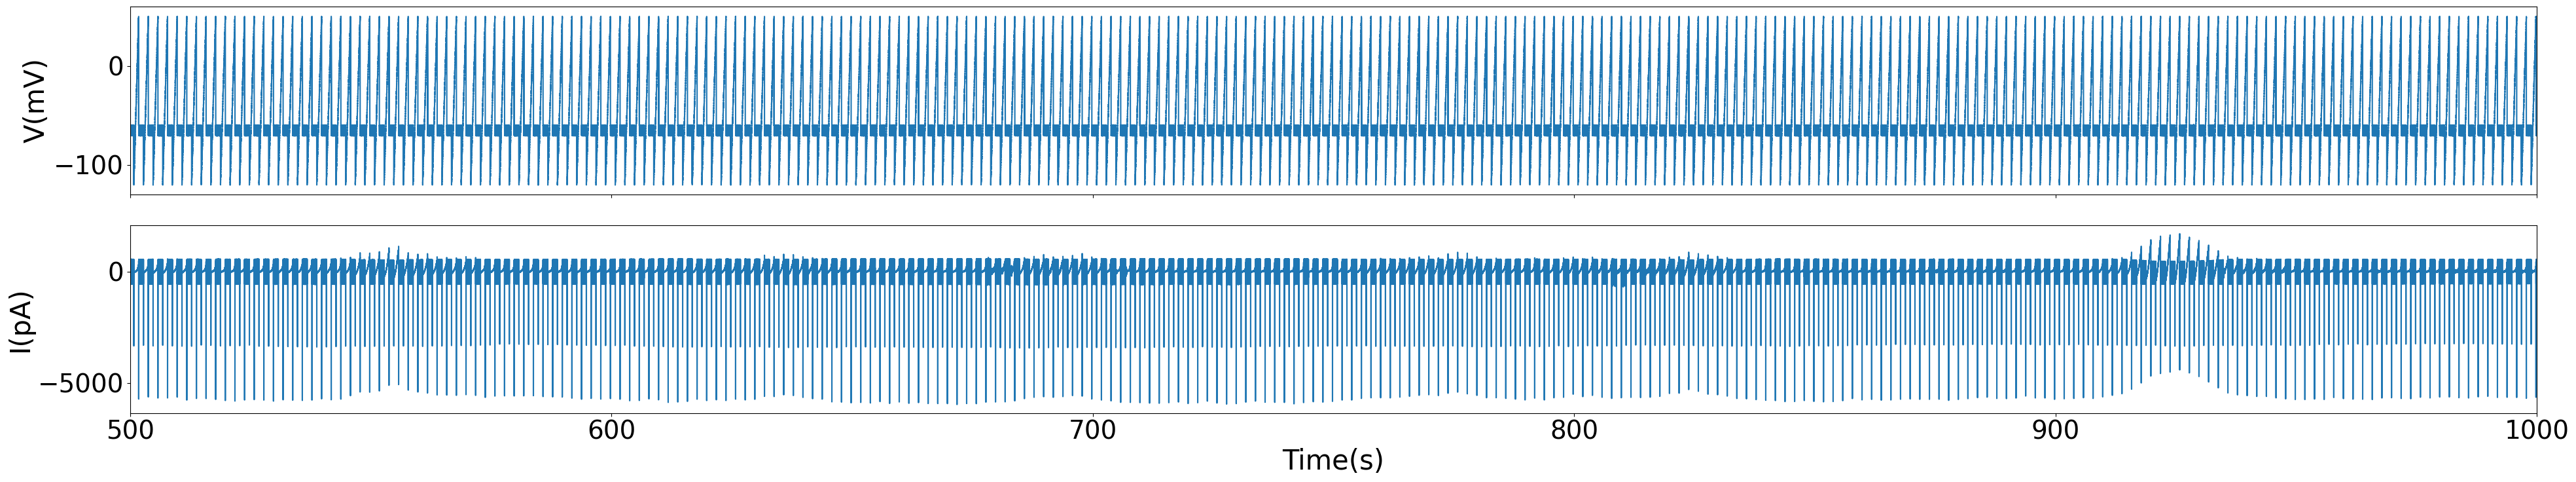

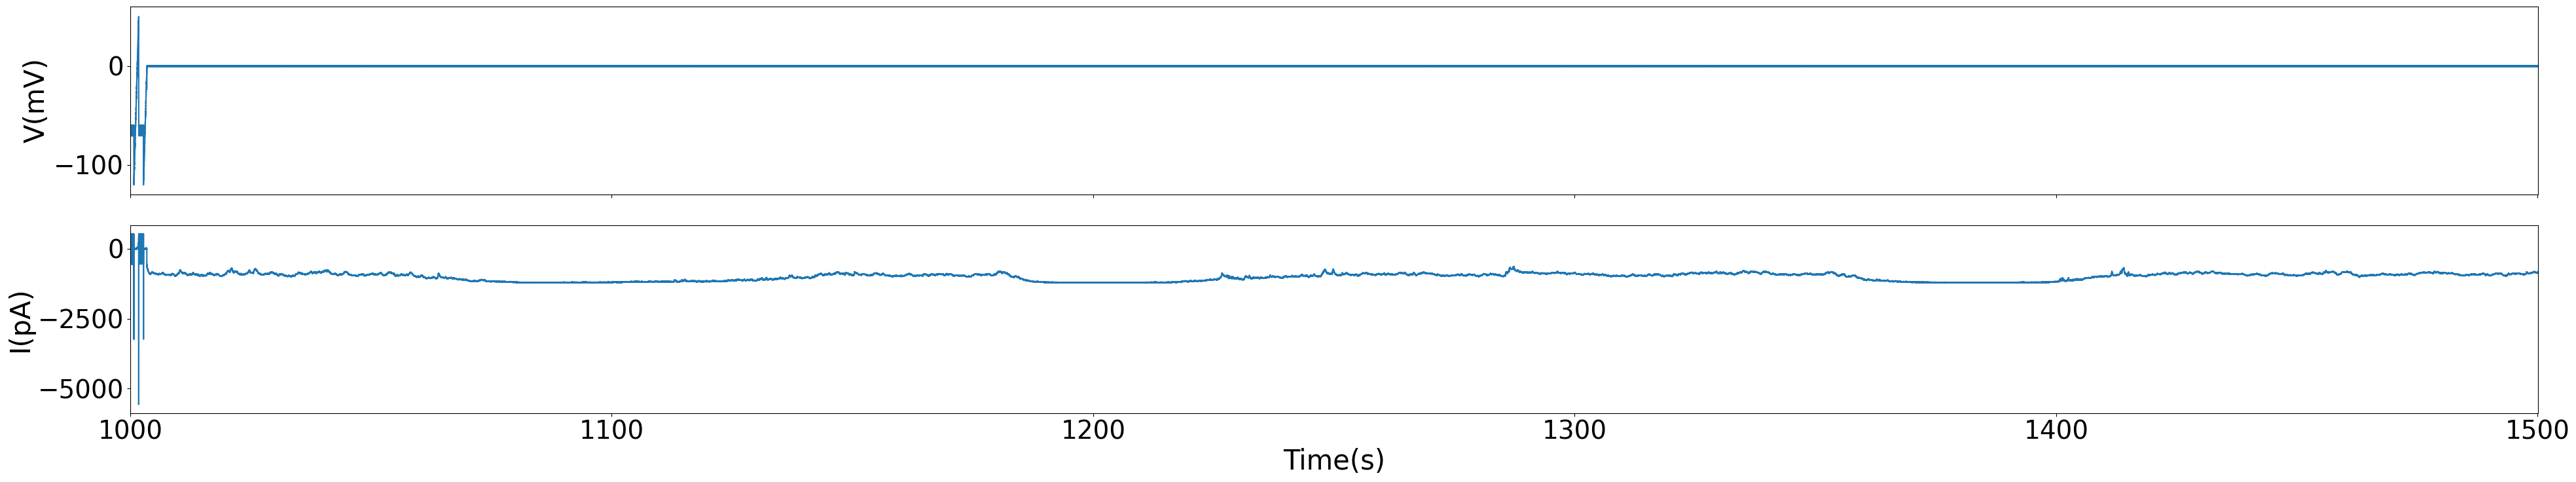

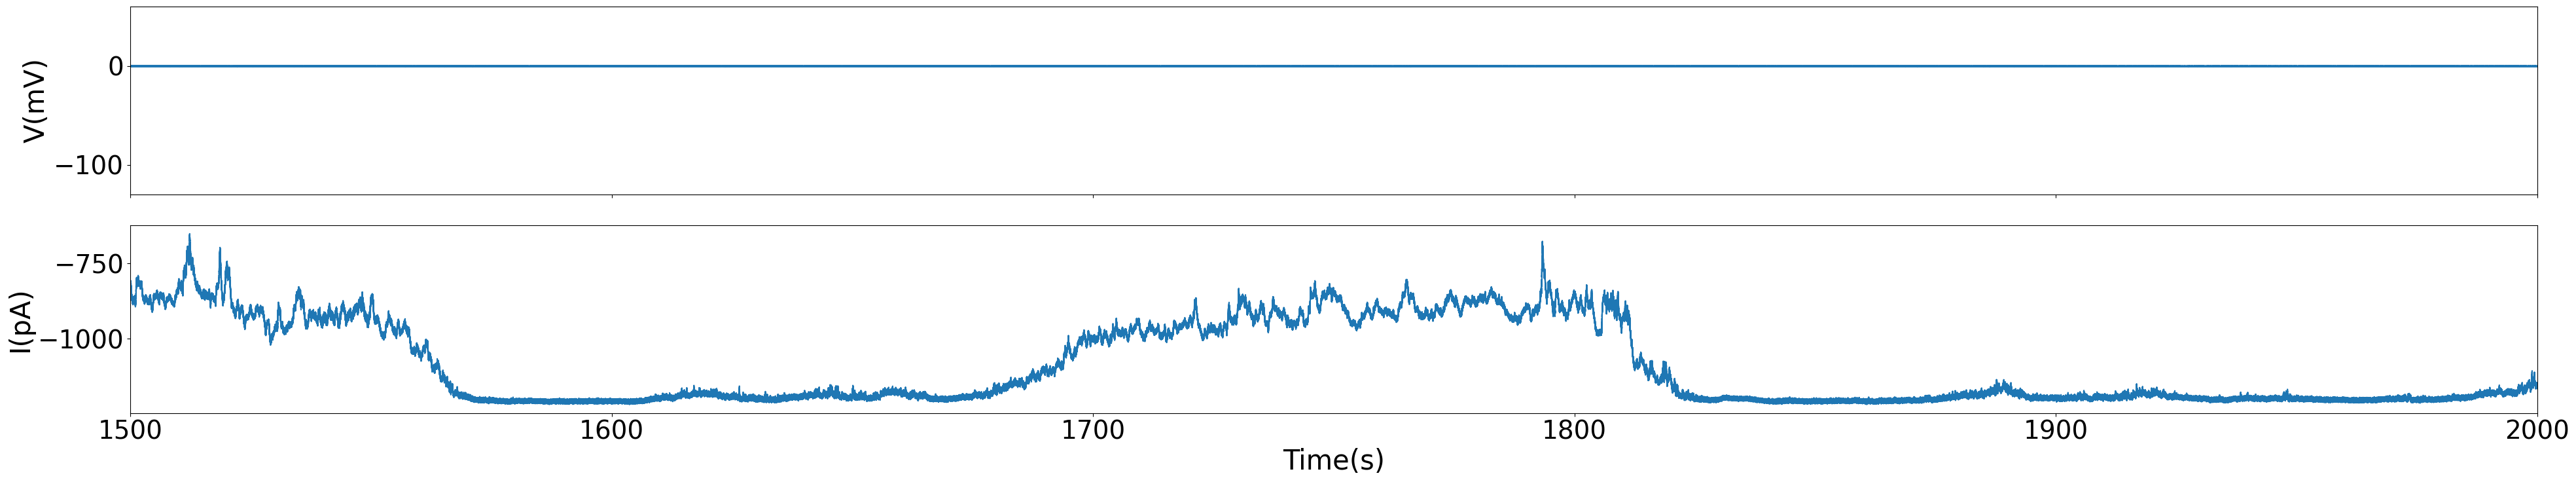

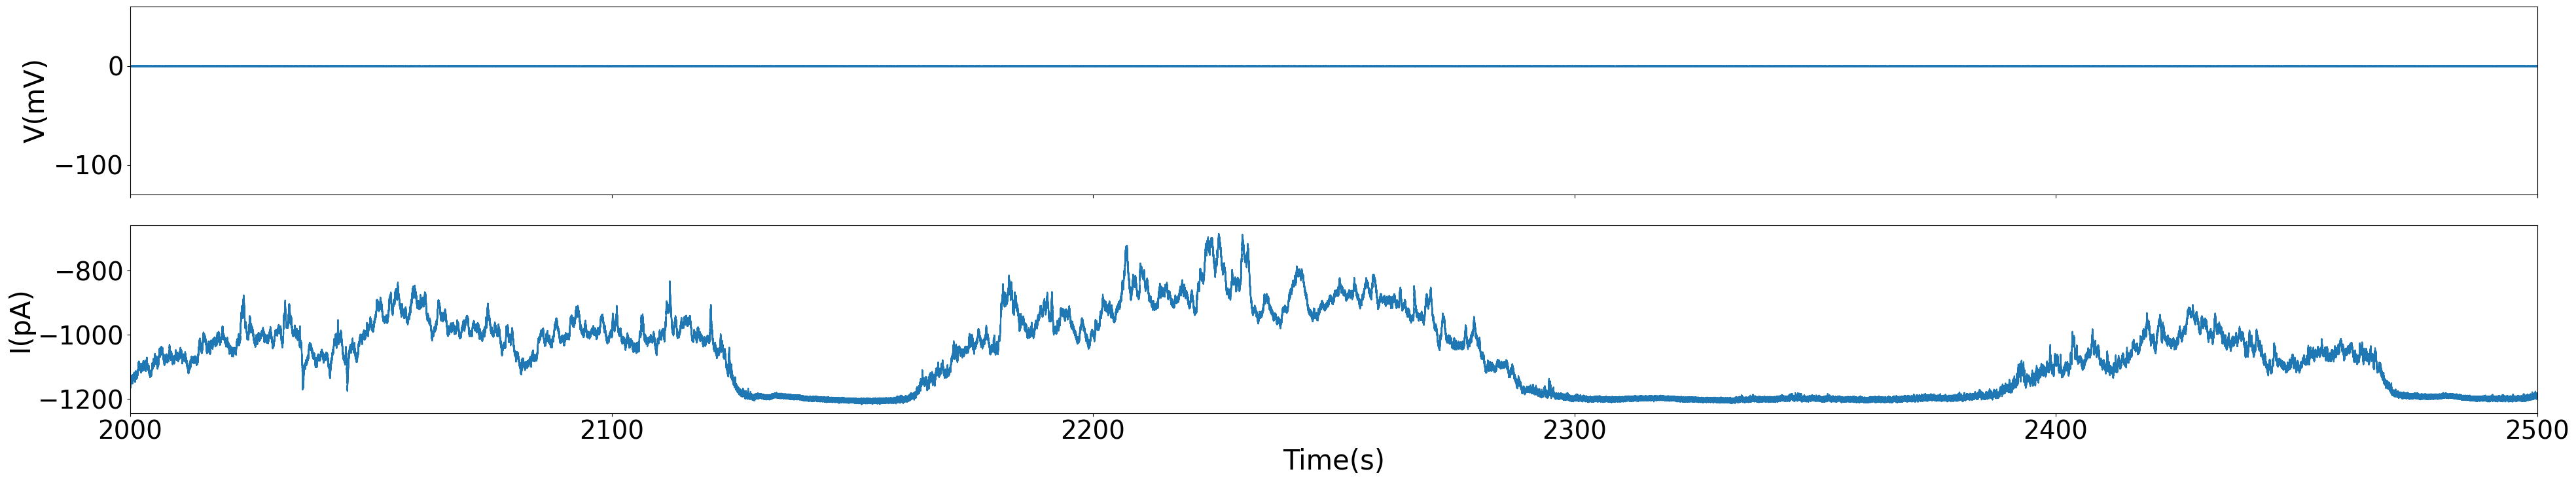

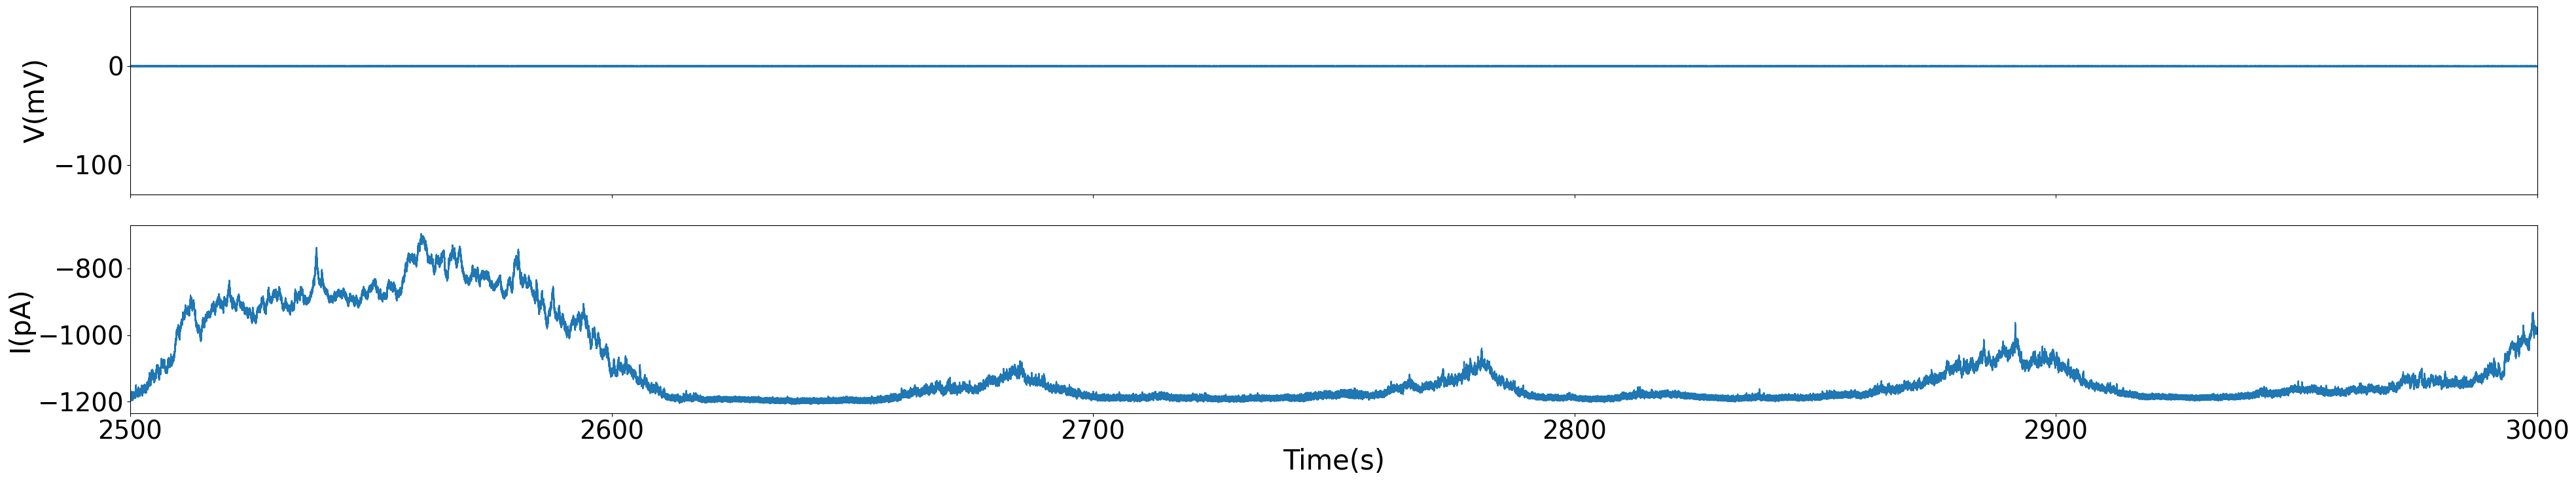

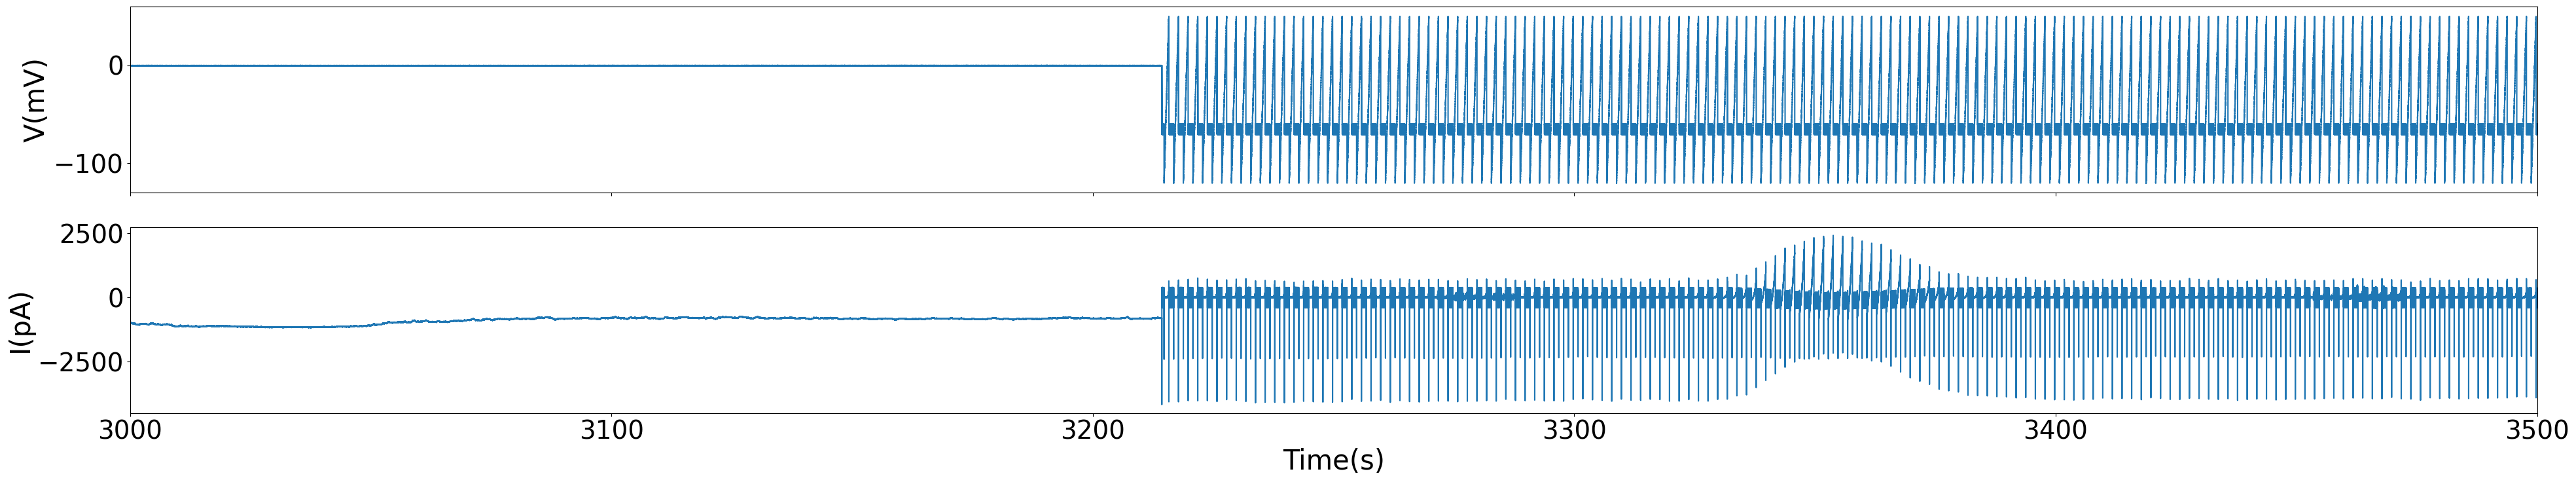

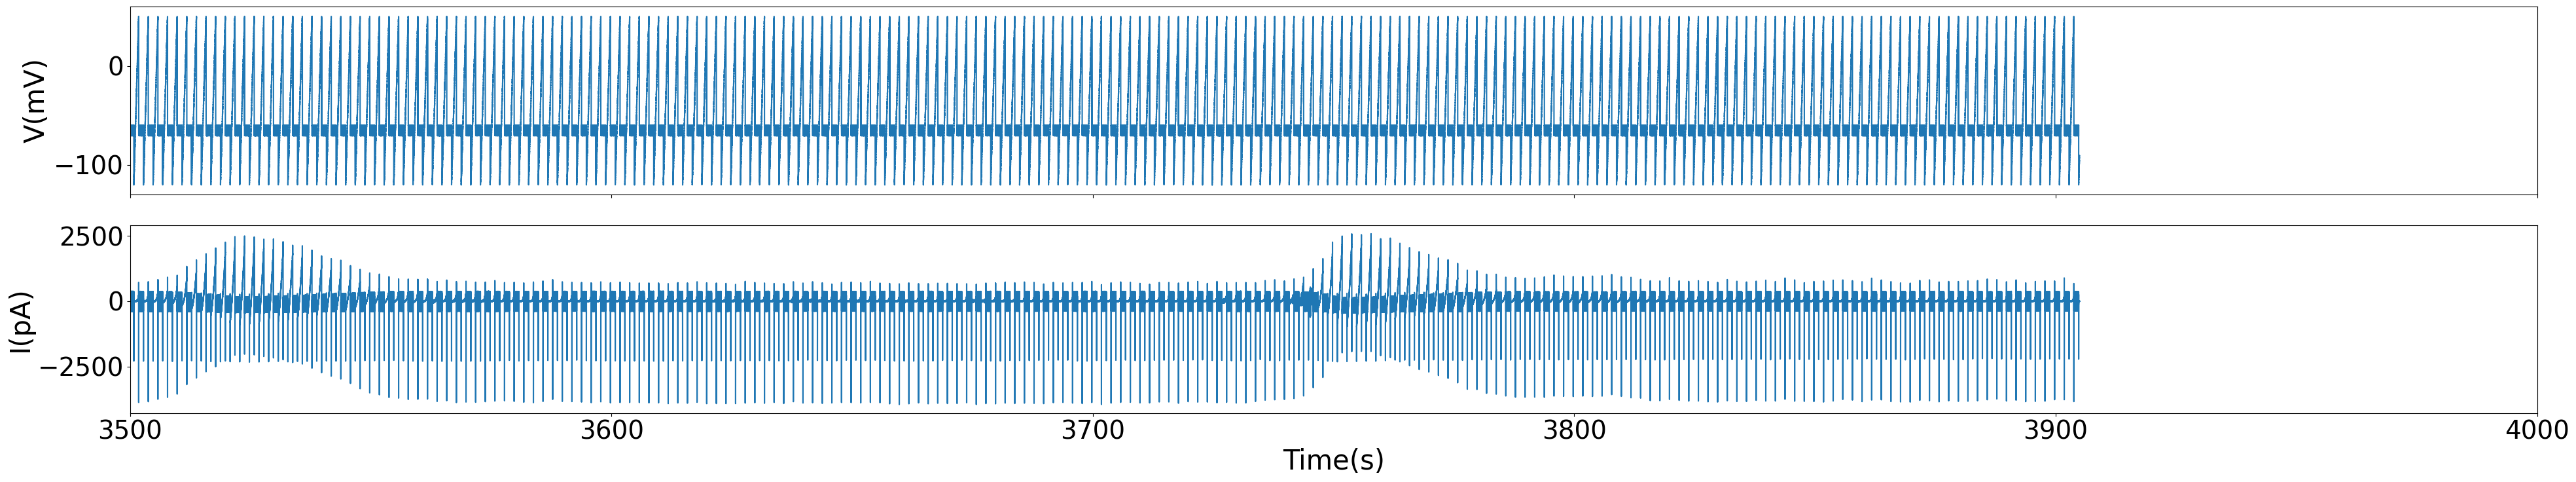

In [6]:
import math
n = math.ceil(times[-1]/500)
SMALL_SIZE = 28
MEDIUM_SIZE = 30
BIGGER_SIZE = 32
for i in range(n):
    fig, axs = plt.subplots(2, 1, sharex=True, figsize = (40,8))
    t_min = i*500
    t_max = (i+1)*500
    axs[0].plot(times[(times>=t_min)&(times<t_max)], V_vc['signal'][(times>=t_min)&(times<t_max)])
    axs[0].set_ylim(-130,60)
    axs[0].set_ylabel('V(mV)')
    #axs[0].set_xlim(times.min(), times.max())
    axs[0].set_xlim(t_min,t_max)
    axs[1].plot(times[(times>=t_min)&(times<t_max)], I_vc['signal'][(times>=t_min)&(times<t_max)])

    axs[1].set_ylabel('I(pA)')
    axs[1].set_xlabel('Time(s)')

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    #plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig.tight_layout()
    plt.show()

In [7]:
def plot_scalebar(ax,x_pos,y_pos,x_len,y_len,thickness = 3,color = 'b'):
    ax.plot([x_pos,x_pos],[y_pos,y_pos+y_len],linewidth = thickness,color = color)
    ax.plot([x_pos,x_pos+x_len],[y_pos,y_pos],linewidth = thickness,color = color)

In [8]:
#index = 54
import os
data_dir = Path(save_dir,'_'.join(df.trial_string[index].split('_')[-3:]) )
#os.mkdir(data_dir)
data_dir

WindowsPath('R:/home/firefly_link/468_patch_clamp/results_profiles/20231129_slip1_cell1')

<IPython.core.display.Javascript object>


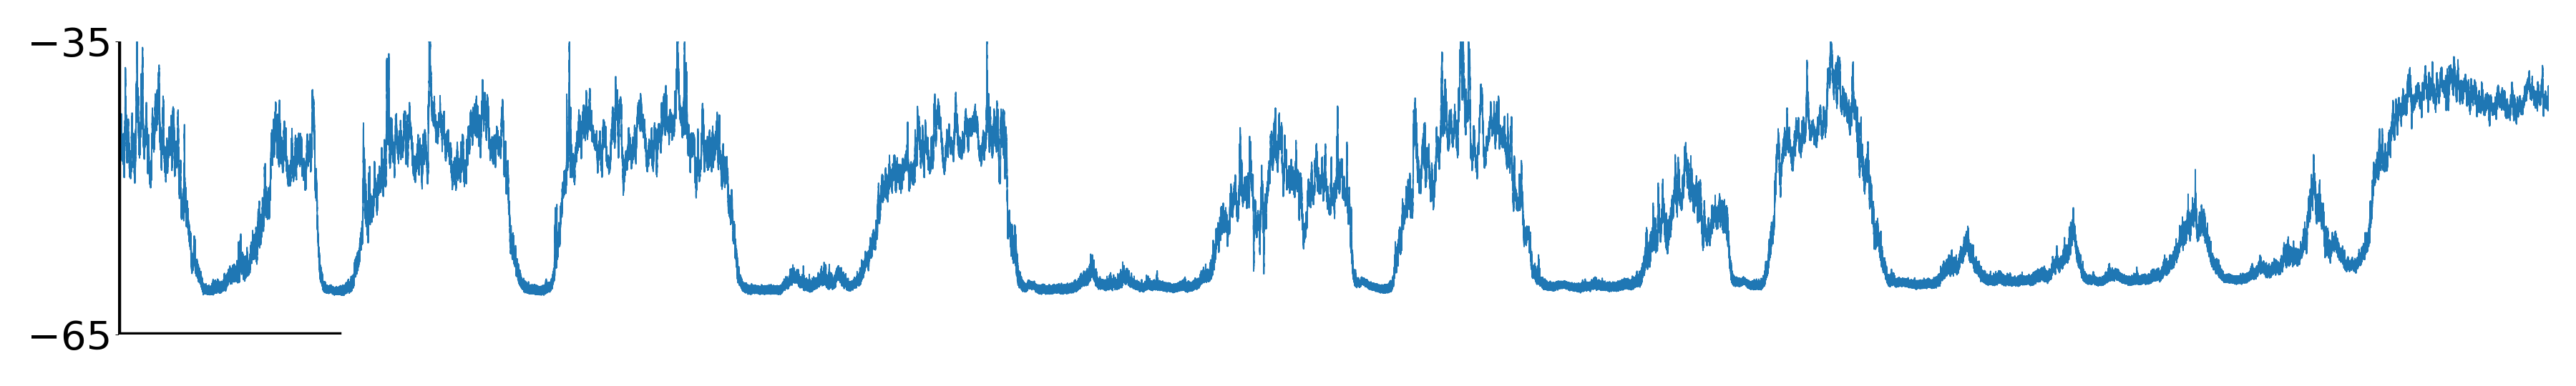

In [11]:
%matplotlib notebook 
fig, axs = plt.subplots(figsize = (40,6))
t_min = 1004
t_max = 3213
t_toxin = 2045.2
axs.plot(times[(times>=t_min)&(times<t_max)], V_cc['signal'][(times>=t_min)&(times<t_max)])
axs.set_ylim(-65,-35)
#axs.set_ylabel('V(mV)')
#axs[0].set_xlim(times.min(), times.max())
axs.set_xlim(t_min,t_max)
#axs.set_xlabel('Time(s)')
plot_scalebar(axs, 1004,-65, 200, 30,thickness = 6, color = 'black')
#axs.vlines(x=t_toxin, ymin=-70, ymax=-20, linewidth=2, color='black', ls = 'dashed')
#axs.axis('off')
#axs[1].plot(times[(times>=t_min)&(times<t_max)], I_cc['signal'][(times>=t_min)&(times<t_max)])

#axs[1].set_ylabel('I(pA)')
#axs[1].set_xlabel('Time(s)')
#axs.axis('off')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)

#axs.get_xaxis().set_ticks([])
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.yticks([-35,-65], fontsize = 45)
plt.xticks([])

fig.tight_layout()
fig.savefig(r'C:\Users\Firefly\Desktop\patch clamp results\20231129_slip1_cell1_cc_recording.eps', format='eps', dpi = 300)
fig.savefig(r'C:\Users\Firefly\Desktop\patch clamp results\20231129_slip1_cell1_cc_recording.png', format='png', dpi = 300)
fig.savefig(Path(data_dir,'20231129_slip1_cell1_cc_recording.eps'), format='eps', dpi = 300)
fig.savefig(Path(data_dir,'20231129_slip1_cell1_cc_recording.png'), format='png', dpi = 300)
plt.show()

In [ ]:
t_start = 10.55
t_ttx = 988.56

t_initial = times[(V<-120)&(times>t_start)][0]


t_before = np.arange(t_initial,t_ttx,2)


Vs_before = []
Is_before = []


for t in t_before:
    Vs_before.append(V[(times>=t)&(times<t+0.999)])
    Is_before.append(I[(times>=t)&(times<t+0.999)])
  

In [ ]:
t_initials = t_before
Vs = Vs_before
Is = Is_before
V_rev = []
for i in range(len(Vs)):
    if len(Vs[i][Is[i] == 0]) != 0:
        V_rev.append(Vs[i][Is[i] == 0].mean())
    else:
        min_index = min(range(len(Is[i])), key=lambda j: abs(Is[i][j]-0))
        V_rev.append(Vs[i][min_index])

print(len(V_rev))
fig, ax = plt.subplots(figsize = (15,5))
ax.scatter(t_initials,V_rev)
#ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
#ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.xlabel('Time(s)')
plt.ylabel('Reversal Potential (mV)')
plt.show()
np.save(Path(data_dir,'V_rev_before.npy'),V_rev)
#np.save(Path(data_dir,'t_all.npy'),t_initials)

<IPython.core.display.Javascript object>


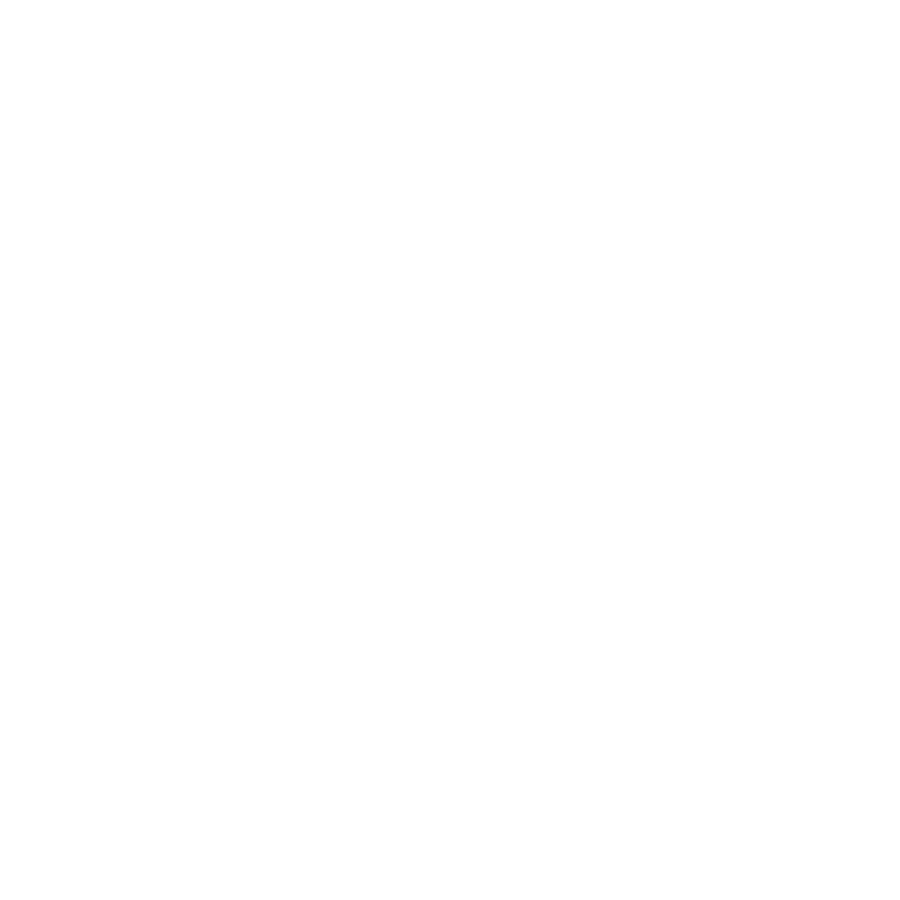

In [56]:
%matplotlib notebook 
from IPython import display
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize = (10,10))
line, = ax.plot(Vs_before[0],Is_before[0])
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
#ax.set_ylim([-300,450])
# remove the ticks from the top and right edges
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Voltage (mV)',loc = 'left')
plt.ylabel('Current (pA)',loc = 'bottom')
plt.ylim([-2500,6000])
plt.xlim([-120,60])
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

def init():
    line.set_ydata([np.nan] * len(Is_before))

def animate(i):
    #ax.clear()
    line.set_xdata(Vs_before[i])
    line.set_ydata(Is_before[i])  # update the data
    #ax.plot(Vs[i],Is[i])
    
ani = FuncAnimation(fig, animate,
                    #init_func=init,
                    interval=50, repeat = False, 
                    frames = len(Is_before), save_count = len(Is_before)
                   )
ani.save('R:/home/firefly_link/468_patch_clamp/results_profiles/20231129_slip1_cell1/V_I_plot_video_before_ibtx.mp4')

plt.show()

In [67]:
t_tx = 3216.24
t_last = 3904.26
t_after_initial = times[(V<-120)&(times>t_tx)][0]
t_after = np.arange(t_after_initial,t_last,2)
Vs_after = []
Is_after = []
for t in t_after:
    Vs_after.append(V[(times>=t)&(times<t+0.999)])
    Is_after.append(I[(times>=t)&(times<t+0.999)])

<IPython.core.display.Javascript object>


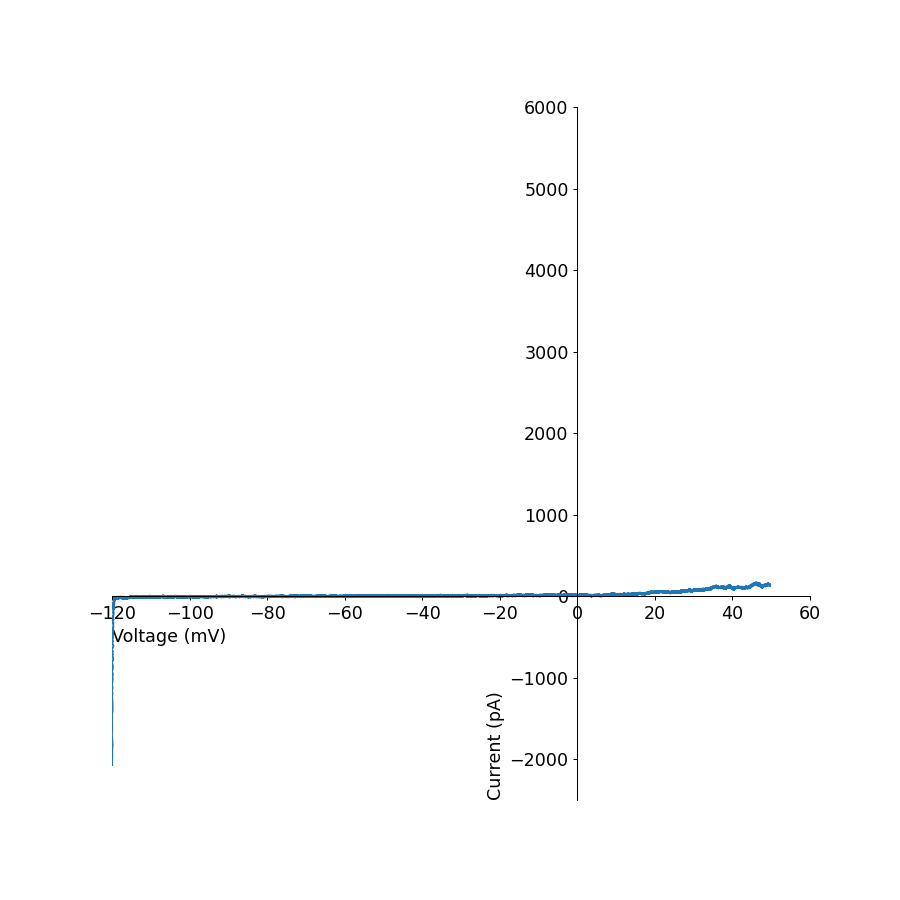

In [61]:
%matplotlib notebook 
from IPython import display
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize = (10,10))
line, = ax.plot(Vs_after[0],Is_after[0])
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
#ax.set_ylim([-300,450])
# remove the ticks from the top and right edges
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlabel('Voltage (mV)',loc = 'left')
plt.ylabel('Current (pA)',loc = 'bottom')
plt.ylim([-2500,6000])
plt.xlim([-120,60])
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

def init():
    line.set_ydata([np.nan] * len(Is_after))

def animate(i):
    #ax.clear()
    line.set_xdata(Vs_after[i])
    line.set_ydata(Is_after[i])  # update the data
    #ax.plot(Vs[i],Is[i])
    
ani = FuncAnimation(fig, animate,
                    #init_func=init,
                    interval=50, repeat = False, 
                    frames = len(Is_after), save_count = len(Is_after)
                   )
ani.save('R:/home/firefly_link/468_patch_clamp/results_profiles/20231129_slip1_cell1/V_I_plot_video_after_ibtx.mp4')

plt.show()

344


<IPython.core.display.Javascript object>


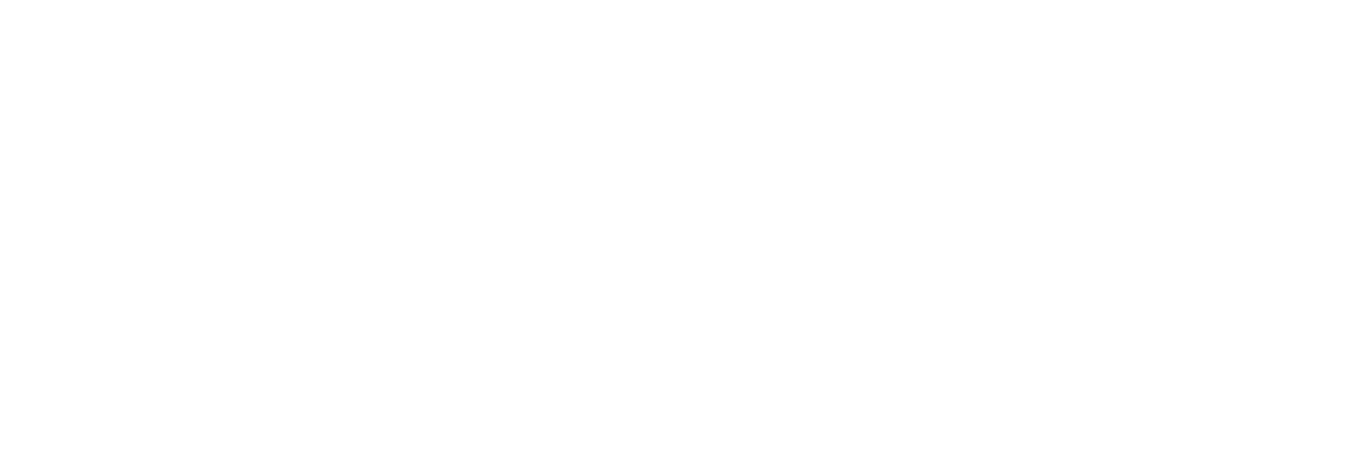

In [68]:
t_initials = t_after
Vs = Vs_after
Is = Is_after
V_rev = []
for i in range(len(Vs)):
    if len(Vs[i][Is[i] == 0]) != 0:
        V_rev.append(Vs[i][Is[i] == 0].mean())
    else:
        min_index = min(range(len(Is[i])), key=lambda j: abs(Is[i][j]-0))
        V_rev.append(Vs[i][min_index])

print(len(V_rev))
fig, ax = plt.subplots(figsize = (15,5))
ax.scatter(t_initials,V_rev)
#ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
#ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.xlabel('Time(s)')
plt.ylabel('Reversal Potential (mV)')
plt.show()
np.save(Path(data_dir,'V_rev_after.npy'),V_rev)
#np.save(Path(data_dir,'t_all.npy'),t_initials)

In [69]:
np.save(Path(data_dir,'t_ramp_after.npy'),t_after)
np.save(Path(data_dir,'t_ramp_before.npy'),t_before)

In [70]:
from scipy import optimize
import math
def model_func(t, A, K, C):
    return A * np.exp(K * t) + C
def fit_exp_nonlinear(t, y):
    opt_parms, parm_cov = optimize.curve_fit(model_func, t, y, p0=[1,-0.5, 1],maxfev = 5000)
    A, K, C = opt_parms
    return A, K, C
def integrate(x, y):
    area = np.trapz(y=y, x=x)
    return area

In [83]:
t_seal_test = []
#t_start = 157.7
#879
for t in np.arange(t_start,t_start+4,2):
    #print(t)
    t_min = t
    t_max = t+0.05
    t_range = times[(times>=t_min)&(times<t_max)]
    I_range = I[(times>=t_min)&(times<t_max)]
    t_max = t_range[I_range.argmax()]
    t_seal_test.append(t_max)
    #print(I_range.max())

<IPython.core.display.Javascript object>


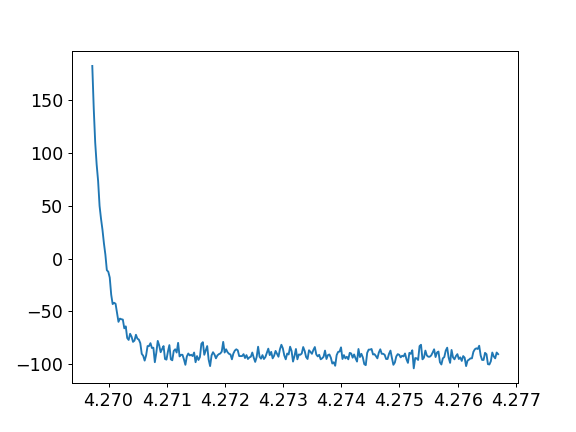

In [84]:
%matplotlib notebook 
V = np.squeeze(V_vc['signal'])
I = np.squeeze(I_vc['signal'])
#t_upper_initial = t_max
#t_lower_initial = t_upper_initial + 0.01
#t_seal = np.arange(t_upper_initial,280,2)
t = times[(times>=t_max)&(times<t_max+0.007)]
ttest = t - t[0]
I_exp = I[(times>=t_max)&(times<t_max+0.007)]
plt.plot(t,I_exp)
plt.show()

<IPython.core.display.Javascript object>


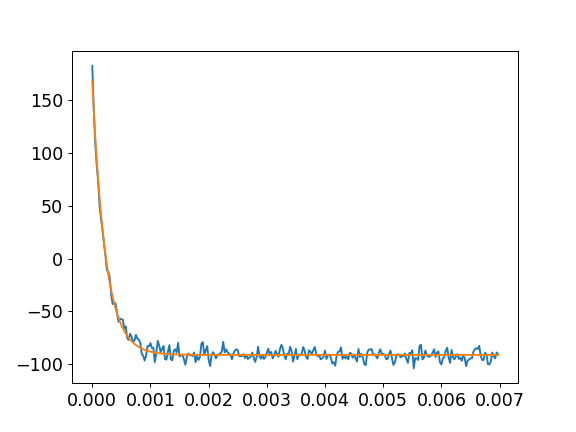

In [85]:
%matplotlib notebook
# Non-linear Fit
A, K, C = fit_exp_nonlinear(ttest, I_exp)
fit_y = model_func(ttest, A, K, C)

plt.plot(ttest, I_exp)
plt.plot(ttest, fit_y)
plt.show()

In [87]:
#compute access resistance over time
#calculate acceptance resistance during breaking in
V = np.squeeze(V_vc['signal'])
I = np.squeeze(I_vc['signal'])
t_seal = []
#879
t_seal_start = t_start
for t in np.arange(t_seal_start,t_ttx,2):
    t_min = t
    t_max = t+0.05
    t_range = times[(times>=t_min)&(times<t_max)]
    I_range = I[(times>=t_min)&(times<t_max)]
    t_max = t_range[I_range.argmax()]
    t_seal.append(t_max)
    #print(I_range.max())
    

In [92]:
from sklearn.metrics import r2_score
Vs_seal_upper = []
Is_seal_upper = []

Vs_seal_lower = []
Is_seal_lower = []

I_exp = []

#I_ss = []
Ra = []
Cm = []
R = []
r2 = []
#t_seal_trial = t_seal[:5]
for t in t_seal:
    V = np.squeeze(V_vc['signal'])
    I = np.squeeze(I_vc['signal'])
    
    V_u = V[(times>=t)&(times<t+0.007)].mean()
    I_u = I[(times>=t)&(times<t+0.007)].mean()

    
    Vs_seal_upper.append(V_u)
    Is_seal_upper.append(I_u)
    
    V_l = V[(times>=t+0.017)&(times<t+0.019)].mean()
    I_l = I[(times>=t+0.017)&(times<t+0.019)].mean()
    
    Vs_seal_lower.append(V_l)
    Is_seal_lower.append(I_l)
    
    #I_ss.append((I_u + I_l)/2)
    
    I_exp = I[(times>=t)&(times<t+0.007)]

    t_u = times[(times>=t)&(times<t+0.007)]
    ttest = t_u - t_u[0]
    
    if (V_u - V_l >15):
        print('Warning', t)
    
    # Non-linear Fit
    A, K, C = fit_exp_nonlinear(ttest, I_exp)
    fit_y = model_func(ttest, A, K, C)
    
    if r2_score(I_exp, fit_y)<0.8:
        print(t)
        %matplotlib notebook
        plt.plot(ttest, I_exp)
        plt.plot(ttest, fit_y)
        plt.show()
        break
    
    r2.append(r2_score(I_exp, fit_y))
    if any(m<0 for m in fit_y):
        integrate_part = fit_y + np.abs(fit_y.min())
        #if any(n < 0 for n in integrate_part):
            #print('Warning - still have netative values here')
    else:
        integrate_part = fit_y - fit_y.min()
    integrate_part = fit_y + np.abs(fit_y.min())
    #if any(n < 0 for n in integrate_part):
        #print('Warning - still have netative values here')
    q1 = integrate(ttest, integrate_part)
    q1 = q1*1e-12
    tau = 1/-K #tau is in seconds
    q2 = (I_u - I_l)*1e-12 * tau #tau is in 1/seconds, deltaI is in amps
    cm = (q1+q2)/(V_u - V_l)
    cm = cm/1e-3 #cm is now in farad
    Cm.append(cm*1e12)#now cm is in pF
    Rt = (V_u - V_l)*1e-3*1e12/(I_u - I_l)# now Rt is in ohms
    R.append(Rt*1e-6)
    #Ra2 - Ra * Rt + Rt * (Tau/Cm) = 0
    a = 1
    b = -Rt 
    c = Rt*(tau/(cm)) 

    dis = b * b - 4 * a * c 
    sqrt_val = math.sqrt(abs(dis))
    Ra1 = (-b+sqrt_val)/2*a
    Ra2 = (-b-sqrt_val)/2*a
    Ra.append(Ra1/1e6)


<IPython.core.display.Javascript object>


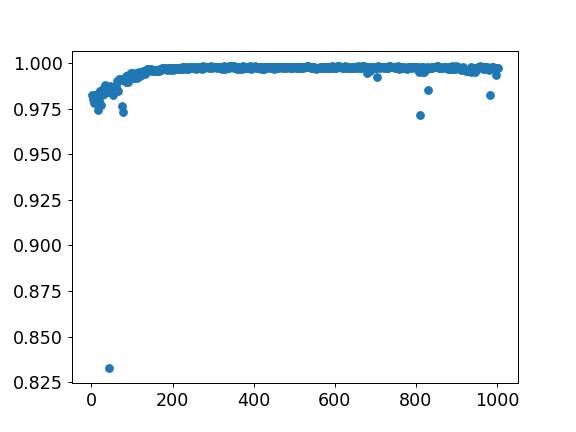

In [98]:
%matplotlib notebook 
plt.scatter(t_seal, r2)

In [95]:
g_before = []
for i in range(len(Is_before)):
    g_before.append((Is_before[i][-1]-Is_before[i][0])/(Vs_before[i][-1]-Vs_before[i][0]))
g_after = []
for i in range(len(Is_after)):
    g_after.append((Is_after[i][-1]-Is_after[i][0])/(Vs_after[i][-1]-Vs_after[i][0]))

In [96]:
np.save(Path(data_dir,'Conductance_before_ibtx.npy'),g_before)
np.save(Path(data_dir,'Conductance_after_ibtx.npy'),g_after)

<IPython.core.display.Javascript object>


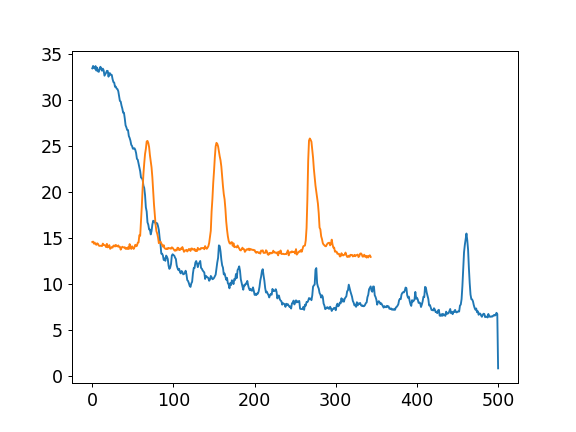

In [99]:
%matplotlib notebook 
plt.plot(g_before)
plt.plot(g_after)

In [100]:
np.save(Path(data_dir,'Ra_before_ibtx.npy'),Ra)
np.save(Path(data_dir,'Cm_before_ibtx.npy'),Cm)

In [101]:
#compute access resistance over time
#calculate acceptance resistance during breaking in
t_seal_after = []
#879
t_seal_start = t_tx
for t in np.arange(t_seal_start,4,2):
    t_min = t
    t_max = t+0.05
    t_range = times[(times>=t_min)&(times<t_max)]
    I_range = I[(times>=t_min)&(times<t_max)]
    t_max = t_range[I_range.argmax()]
    t_seal.append(t_max)
    #print(I_range.max())


<IPython.core.display.Javascript object>


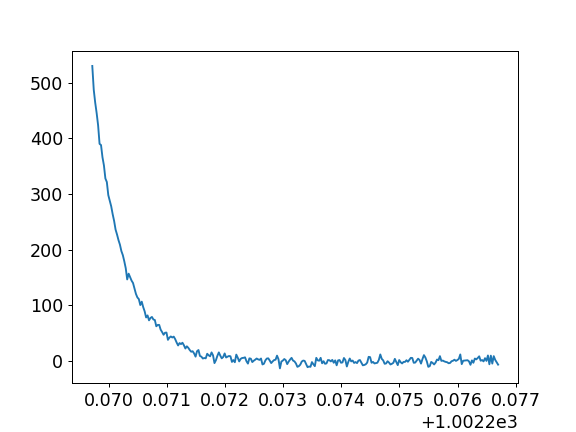

In [102]:
%matplotlib notebook 
V = np.squeeze(V_vc['signal'])
I = np.squeeze(I_vc['signal'])
#t_upper_initial = t_max
#t_lower_initial = t_upper_initial + 0.01
#t_seal = np.arange(t_upper_initial,280,2)
t = times[(times>=t_max)&(times<t_max+0.007)]
ttest = t - t[0]
I_exp = I[(times>=t_max)&(times<t_max+0.007)]
plt.plot(t,I_exp)
plt.show()

<IPython.core.display.Javascript object>


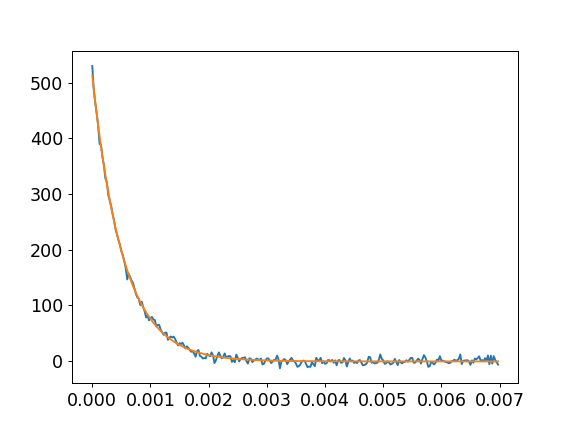

In [103]:
%matplotlib notebook
# Non-linear Fit
A, K, C = fit_exp_nonlinear(ttest, I_exp)
fit_y = model_func(ttest, A, K, C)

plt.plot(ttest, I_exp)
plt.plot(ttest, fit_y)
plt.show()

In [118]:
t_seal_after = []
#879
t_seal_start = t_tx
for t in np.arange(t_seal_start,t_last,2):
    t_min = t
    t_max = t+0.05
    t_range = times[(times>=t_min)&(times<t_max)]
    I_range = I[(times>=t_min)&(times<t_max)]
    t_max = t_range[I_range.argmax()]
    t_seal_after.append(t_max)
    #print(I_range.max())
    

In [119]:
Vs_seal_upper = []
Is_seal_upper = []

Vs_seal_lower = []
Is_seal_lower = []

I_exp = []

#I_ss = []
Ra_after = []
Cm_after = []
R_after = []
r2_after = []
#t_seal_trial = t_seal[:5]
for t in t_seal_after:
    V = np.squeeze(V_vc['signal'])
    I = np.squeeze(I_vc['signal'])
    
    V_u = V[(times>=t)&(times<t+0.007)].mean()
    I_u = I[(times>=t)&(times<t+0.007)].mean()

    
    Vs_seal_upper.append(V_u)
    Is_seal_upper.append(I_u)
    
    V_l = V[(times>=t+0.017)&(times<t+0.019)].mean()
    I_l = I[(times>=t+0.017)&(times<t+0.019)].mean()
    
    Vs_seal_lower.append(V_l)
    Is_seal_lower.append(I_l)
    
    #I_ss.append((I_u + I_l)/2)
    
    I_exp = I[(times>=t)&(times<t+0.007)]

    t_u = times[(times>=t)&(times<t+0.007)]
    ttest = t_u - t_u[0]
    
    if (V_u - V_l >12):
        print('Warning', t)
    
    # Non-linear Fit
    A, K, C = fit_exp_nonlinear(ttest, I_exp)
    fit_y = model_func(ttest, A, K, C)
    r2_after.append(r2_score(I_exp, fit_y))
    if any(m<0 for m in fit_y):
        integrate_part = fit_y + np.abs(fit_y.min())
        #if any(n < 0 for n in integrate_part):
            #print('Warning - still have netative values here')
    else:
        integrate_part = fit_y - fit_y.min()
    integrate_part = fit_y + np.abs(fit_y.min())
    #if any(n < 0 for n in integrate_part):
        #print('Warning - still have netative values here')
    q1 = integrate(ttest, integrate_part)
    q1 = q1*1e-12
    tau = 1/-K #tau is in seconds
    q2 = (I_u - I_l)*1e-12 * tau #tau is in 1/seconds, deltaI is in amps
    cm = (q1+q2)/(V_u - V_l)
    cm = cm/1e-3 #cm is now in farad
    Cm_after.append(cm*1e12)#now cm is in pF
    Rt = (V_u - V_l)*1e-3*1e12/(I_u - I_l)# now Rt is in ohms
    R_after.append(Rt*1e-6)
    #Ra2 - Ra * Rt + Rt * (Tau/Cm) = 0
    a = 1
    b = -Rt 
    c = Rt*(tau/(cm)) 

    dis = b * b - 4 * a * c 
    sqrt_val = math.sqrt(abs(dis))
    Ra1 = (-b+sqrt_val)/2*a
    Ra2 = (-b-sqrt_val)/2*a
    Ra_after.append(Ra1/1e6)

<IPython.core.display.Javascript object>


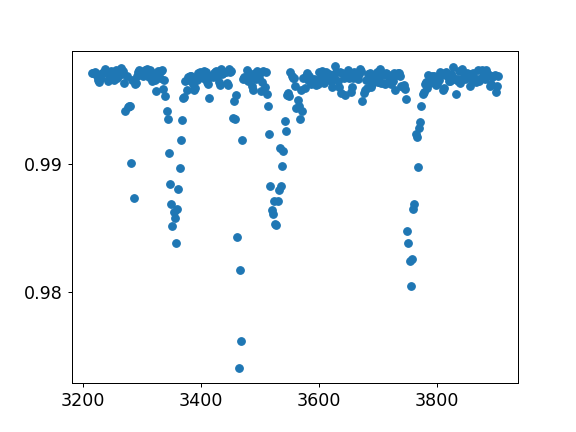

In [120]:
%matplotlib notebook 
plt.scatter(t_seal_after,r2_after)

In [121]:
np.save(Path(data_dir,'Ra_after_ibtx.npy'),Ra_after)
np.save(Path(data_dir,'Cm_after_ibtx.npy'),Cm_after)

In [126]:
np.save(Path(data_dir,'t_seal_before_ibtx.npy'),t_seal)
np.save(Path(data_dir,'t_seal_after_ibtx.npy'),t_seal_after)